In [40]:
#%matplotlib notebook
import sys
import os

# Standard modules used through the notebook 
import numpy as np
import matplotlib.pyplot as plt

# Tools specific for this tutorial
# They are in the .py files accompaining this notebook 
from bundle_adjust import ba_utils               
from bundle_adjust import rpc_fit
from IS18 import vistools               # display tools
from IS18 import utils                  # IO tools
from IS18 import rectification          # rectification tools
from IS18 import stereo                 # stereo tools
from IS18 import triangulation          # triangulation tools

import s2p
import pickle
import rpcm
import glob
import json
import copy
import timeit
import srtm4

# Display and interface settings (just for the notebook interface)
%load_ext autoreload
%autoreload 2
np.set_printoptions(linewidth=150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Experiment name 

In [42]:
exp_name = 'skysat_coal_singledate' #'skysat_L1A_dona_juana2' #
input_dir = os.path.join('exp/',exp_name)
src_dir = os.path.join('data/',exp_name)

if not os.path.exists(src_dir):
    print('ERROR: source path does not exist!')
else:
    os.makedirs(input_dir, exist_ok=True)

### Read SkySat images and RPCs

In [43]:
# read tiff images 
myimages = np.sort(glob.glob(src_dir+'/*.tif')).tolist()
#myimages = myimages[:3]
print('Found {} images'.format(len(myimages)))
n_cam = len(myimages)
print('Number of images to be used:', n_cam)

from bundle_adjust import data_loader as loader
mycrops = loader.load_image_crops(myimages)

# load RPC coefficients
myrpcs = [rpcm.rpc_from_rpc_file(os.path.splitext(im)[0]+'_RPC.TXT') for im in myimages]
#myrpcs = [rpcm.rpc_from_geotiff(x) for x in myimages]
print('Finished loading RPC coefficients')

#load aoi
aoi = loader.load_aoi_from_geotiffs(myimages, rpcs=myrpcs)

# update myimages list
pickle_out = open(input_dir+'/myimages.pickle','wb')
pickle.dump([os.path.basename(imagefn) for imagefn in myimages], pickle_out)
pickle_out.close()

Found 9 images
Number of images to be used: 9
Loading 9 image crops / 9

Finished loading RPC coefficients
Defining aoi from union of all geotiff footprints... 9 / 9 done



In [4]:
from bundle_adjust import ba_triangulate

pts1 = np.array([[1980.42382812, 1493.98681641,  783.93994141],
                 [ 193.30801392,  198.57647705,  110.44727325]]).T

pts2 = np.array([[1965.15698242, 1478.35095215,  766.73248291],
                 [1315.32214355, 1322.24987793, 1234.59606934]]).T



In [5]:
pts3d, err = ba_triangulate.rpc_triangulation(myrpcs[0], myrpcs[1], pts1[::-1], pts2[::-1])

print(pts3d, err)

[[              nan               nan               nan]
 [ 4741076.04090372  2968510.37175077 -3056242.69762649]
 [              nan               nan               nan]] [[     nan]
 [2.641123]
 [     nan]]


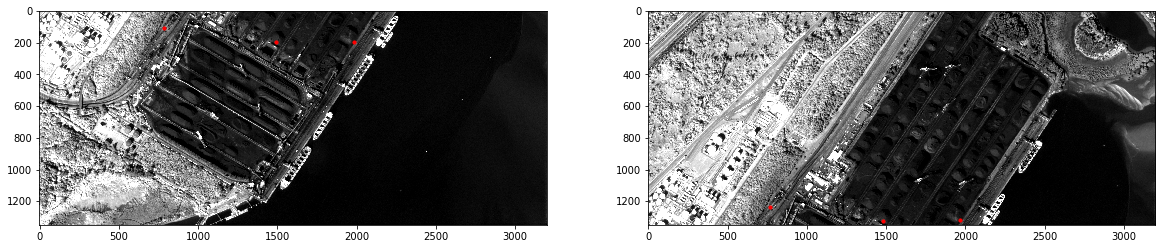

In [7]:
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow((mycrops[0]['crop']), cmap="gray")
ax2.imshow((mycrops[1]['crop']), cmap="gray")
ax1.scatter(x=pts1[:, 0], y=pts1[:, 1], c='r', s=10)
ax2.scatter(x=pts2[:, 0], y=pts2[:, 1], c='r', s=10)
plt.show()

### Set bundle adjustment input and load pipeline

In [46]:
ba_input_data = {}
ba_input_data['input_dir'] = input_dir
ba_input_data['output_dir'] = input_dir
ba_input_data['n_adj'] = 0
ba_input_data['n_new'] = len(myimages)
ba_input_data['image_fnames'] = myimages
ba_input_data['crops'] = mycrops
ba_input_data['rpcs'] = myrpcs
ba_input_data['cam_model'] = 'perspective'
ba_input_data['masks'] = None
ba_input_data['aoi'] = aoi

config = {'s2p': False, 
         'matching_thr': 0.8,
        'use_masks': False,
        'filter_pairs': True,
        'max_kp': 3000,
        'optimal_subset': True,
        'K': 60,
        'tie_points': False,
        'continue': False}


from bundle_adjust.ba_pipeline import BundleAdjustmentPipeline

ba_pipeline = BundleAdjustmentPipeline(ba_input_data, tracks_config=config, verbose=True)
#ba_pipeline.display_aoi()

#ba_pipeline.run()

Bundle Adjustment Pipeline created
-------------------------------------------------------------
Configuration:
    - input_dir:    exp/skysat_coal_singledate
    - output_dir:   exp/skysat_coal_singledate
    - n_new:        9
    - n_adj:        0
    - cam_model:    perspective
-------------------------------------------------------------

Approx. rpcs as perspective projection matrices... 9 / 9


Estimating camera positions...
done!



Building feature tracks - satellite scenario - using opencv SIFT

Parameters:
      use_masks:    False
      matching_thr: 0.8



Running feature detection...

Found 3000 keypoints in image 0
Found 3000 keypoints in image 1
Found 3000 keypoints in image 2
Found 3000 keypoints in image 3
Found 3000 keypoints in image 4
Found 3000 keypoints in image 5
Found 3000 keypoints in image 6
Found 3000 keypoints in image 7
Found 3000 keypoints in image 8

...done in 8.58 seconds

Computing pairs to match...

     22 / 36 pairs suitable to match
     16 / 36 pairs suitable to triangulate
22 new pairs to be matched

...done in 0.01 seconds

Matching...

Pair (4,7) -> 536 matches (536 after utm consistency check)
Pair (1,3) -> 152 matches (152 after utm consistency check)
Pair (2,6) -> 248 matches (248 after utm consistency check)
Pair (5,6) -> 612 matches (612 after utm consistency check)
Pair (4,5) -> 220 matches (220 after utm consistency check)
Pair (1,4) -> 643 matches (643 after utm consisten

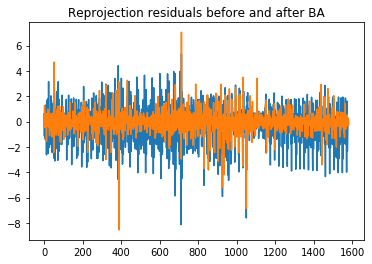

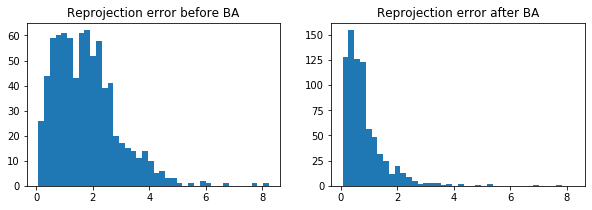

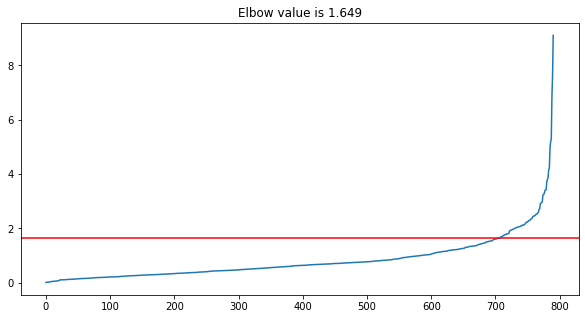


Removal of outliers according to reprojection error completed
Deleted 61 observations (7.71%) and 9 tracks (4.37%)
     - Obs per cam before : [ 20 138  94  72 104  94  42 166  61]
     - Obs per cam after  : [ 20 126  74  69  98  80  36 153  59]


Defining bundle adjustment parameters...
     - cam_params_to_optimize: ['R']

197 3d points, 0 fixed and 197 to be optimized
9 cameras, 0 fixed and 9 to be optimized
3 parameters to optimize per camera


Running bundle adjustment...
     - loss: linear
     - ftol: 0.0001
     - xtol: 1e-10

Shape of Jacobian sparsity: 1430x618
`ftol` termination condition is satisfied.
Function evaluations 7, initial cost 1.3408e+03, final cost 1.8008e+02, first-order optimality 1.84e+06.
Optimization took 0 seconds

Error before BA (mean / median): 1.65 / 1.55
Error after  BA (mean / median): 0.61 / 0.56


Bundle adjusted projection matrices successfully saved at exp/skysat_coal_singledate/P_adj


Bundle adjusted RPCs successfully saved at exp/skysat_coa

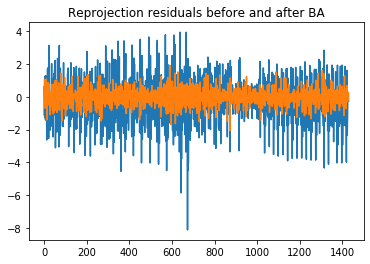

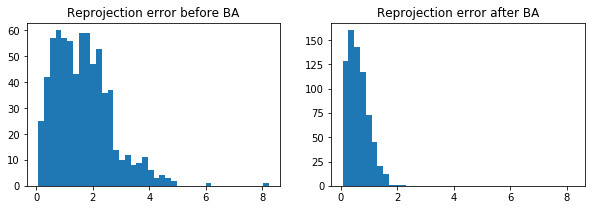

In [56]:
ba_pipeline.run()

Bundle Adjustment Pipeline created
-------------------------------------------------------------
Configuration:
    - input_dir:    exp/skysat_coal_singledate
    - output_dir:   exp/skysat_coal_singledate
    - n_new:        9
    - n_adj:        0
    - cam_model:    perspective
-------------------------------------------------------------

Approx. rpcs as perspective projection matrices... 9 / 9


Estimating camera positions...
done!

Building feature tracks - satellite scenario - using opencv SIFT

Parameters:
      use_masks:    False
      matching_thr: 0.8



Running feature detection...

Found 3000 keypoints in image 0
Found 3000 keypoints in image 1
Found 3000 keypoints in image 2
Found 3000 keypoints in image 3
Found 3000 keypoints in image 4
Found 3000 keypoints in image 5
Found 3000 keypoints in image 6
Found 3000 keypoints in image 7
Found 3000 keypoints in image 8

...done in 8.829139225184917 seconds

Computing pairs to match...

     22 / 36 pairs suitable to match
    

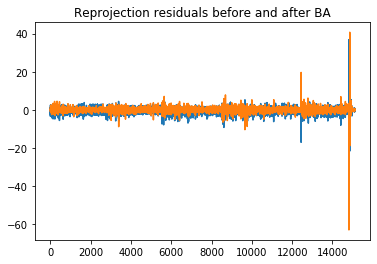

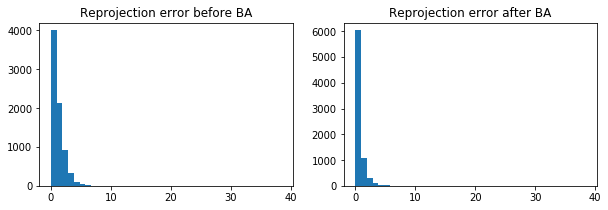

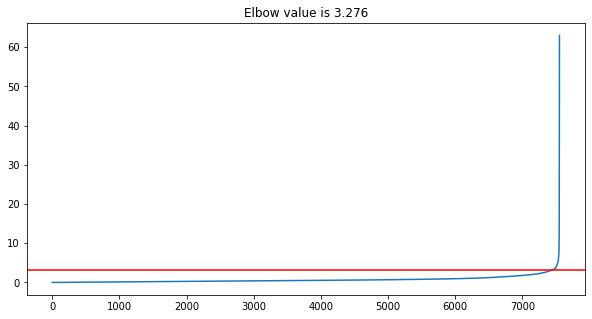


Removal of outliers according to reprojection error completed
Deleted 91 observations (1.20%) and 35 tracks (1.09%)
     - Obs per cam before : [ 438  907  932  781 1022 1267  772  881  554]
     - Obs per cam after  : [ 432  882  905  767 1016 1257  756  864  542]


Defining bundle adjustment parameters...
     - cam_params_to_optimize: ['R']

3165 3d points, 0 fixed and 3165 to be optimized
9 cameras, 0 fixed and 9 to be optimized
3 parameters to optimize per camera


Running bundle adjustment...
     - loss: linear
     - ftol: 0.0001
     - xtol: 1e-10

Shape of Jacobian sparsity: 14842x9522
`ftol` termination condition is satisfied.
Function evaluations 6, initial cost 8.2837e+03, final cost 2.3754e+03, first-order optimality 1.50e+06.
Optimization took 1 seconds

Error before BA (mean / median): 1.14 / 0.88
Error after  BA (mean / median): 0.62 / 0.50


Bundle adjusted projection matrices successfully saved at exp/skysat_coal_singledate/P_adj


Bundle adjusted RPCs successfully 

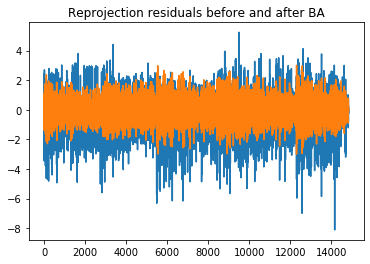

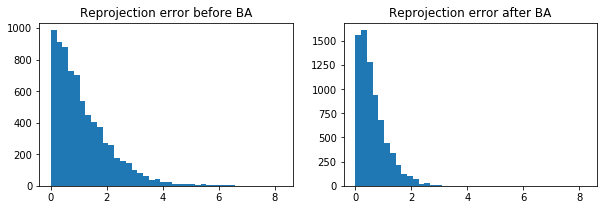

In [212]:
ba_input_data = {}
ba_input_data['input_dir'] = input_dir
ba_input_data['output_dir'] = input_dir
ba_input_data['n_adj'] = 0
ba_input_data['n_new'] = len(myimages)
ba_input_data['image_fnames'] = myimages
ba_input_data['crops'] = mycrops
ba_input_data['rpcs'] = myrpcs
ba_input_data['cam_model'] = 'perspective'
ba_input_data['masks'] = None
ba_input_data['aoi'] = aoi

config = {'s2p': False,
           'matching_thr': 0.8,
           'use_masks': False,
           'filter_pairs': True,
           'max_kp': 3000,
           'optimal_subset': False,
           'K': 30,
           'tie_points': False,
           'continue': False}
            

from bundle_adjust.ba_pipeline import BundleAdjustmentPipeline

ba_pipeline = BundleAdjustmentPipeline(ba_input_data, tracks_config=config, verbose=True)
#ba_pipeline.display_aoi()

ba_pipeline.run()

### Visualize a feature track before and after Bundle Adjustment

Verify that the projections after Bundle Adjustment are closer to the observations of the feature track.

[[ 4740239.32985239  2967819.96532417 -3056162.3710609 ]
 [ 4740040.36662768  2968172.9659302  -3056125.02877186]
 [ 4739717.58967631  2968670.80210655 -3056149.73019342]
 ...
 [ 4739705.07283467  2968838.20753462 -3056067.85931582]
 [ 4739721.34837235  2968942.07907071 -3055950.96245472]
 [ 4739801.96320335  2968915.0019035  -3055807.71159909]]
Displaying feature track with index 2706, length 2

3D location (initial)  : [ 4739862.14244997  2968364.88427295 -3056260.0139488 ]
3D location (after BA) : [ 4739846.5893367   2968362.39361337 -3056251.33736796] 

 ----> Real 2D loc in im 1  (yellow) =  [1174.73327637 1130.70043945]
 ----> Proj 2D loc in im 1  before BA (red) =  [1174.73327598 1130.70043921]
 ----> Proj 2D loc in im 1  after  BA (green) =  [1171.88824441 1129.96926798]
              Reprojection error beofre BA: 4.550117460615497e-07
              Reprojection error after  BA: 2.937485071111296


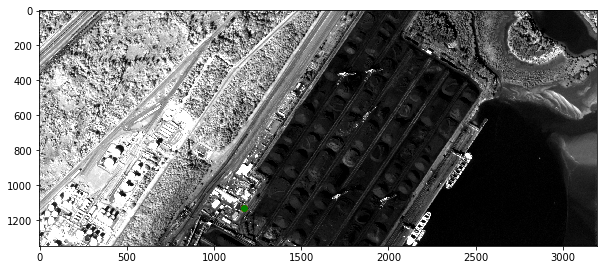

 ----> Real 2D loc in im 8  (yellow) =  [1176.13476562  127.43722534]
 ----> Proj 2D loc in im 8  before BA (red) =  [1185.06493687  129.71289353]
 ----> Proj 2D loc in im 8  after  BA (green) =  [1179.00013586  128.16497582]
              Reprojection error beofre BA: 9.215564233568953
              Reprojection error after  BA: 2.9563435778268565


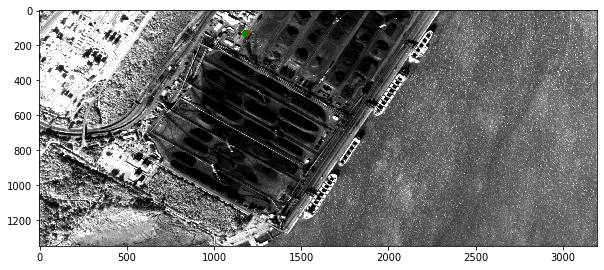

Mean reprojection error before BA: 4.607782344290349
Mean reprojection error after BA: 2.946914324469076


In [6]:
max_err_idx = ba_pipeline.ba_params.pts_ind[np.argmax(ba_pipeline.init_e)]
ba_pipeline.visualize_feature_track(track_idx=max_err_idx)

#ba_pipeline.visualize_feature_track()

In [7]:
ba_pipeline.save_crops()


Image crops were saved at exp/skysat_coal_singledate/images



### Detailed view of initial-final reprojection errors for a particular image

This can be used to analyse a particular image in detail.

path to image: data/skysat_coal_singledate/20190617_075138_ssc2d2_0005_basic_panchromatic_dn.tif
mean reprojection error before BA: 0.6405
mean reprojection error after  BA: 0.7502


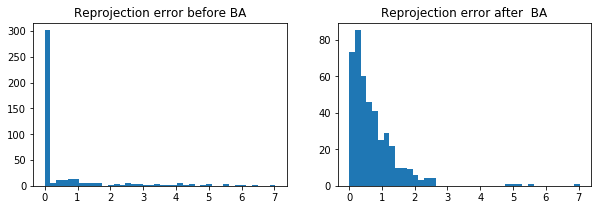

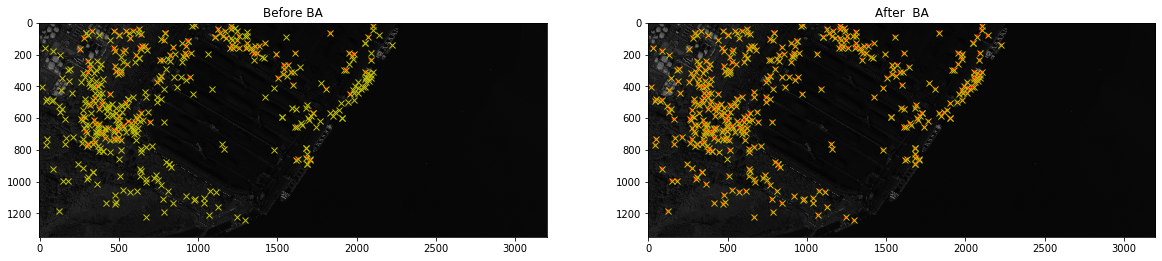

In [8]:
ba_pipeline.analyse_reprojection_error_per_image(0)

In [9]:
ba_pipeline.compute_image_weights_after_bundle_adjustment()

[3.1043414763581394,
 7.113846324298056,
 5.092016811470061,
 5.136729972440176,
 6.158524523498298,
 5.12886241855932,
 3.1016987958459206,
 7.128315828140659,
 5.102311911687334]

### Do the 3D points fall in the correct place?

Verify that the projection of the bounding box containing the point cloud of the scene falls in the correct area of the Earth.

In [10]:
from bundle_adjust.ba_triangulate import project_xyz_bbx_on_map

project_xyz_bbx_on_map(ba_pipeline.ba_params.pts3d_ba, map_zoom=14)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

### Save point clouds of SIFT keypoints before and after Bundle Adjustment 

In [207]:
from bundle_adjust.ba_triangulate import write_feature_tracks_stereo_point_clouds

im_ind = [0, 1, 2, 3, 4, 5]
all_pairs = [(im_i, im_j) for im_i in im_ind for im_j in im_ind if im_i != im_j and im_i<im_j]

if ba_pipeline.cam_model == 'perspective':
    write_feature_tracks_stereo_point_clouds(all_pairs, ba_pipeline.C, 
                                             ba_pipeline.cameras, ba_pipeline.corrected_cameras, 
                                             output_dir=input_dir, min_pts=0)
else:
    print('This is not implemented yet for rpc/affine camera models')
    

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]
Writing point clouds of SIFT keypoints...
...done!



### Check baseline distances

0 (0,1) 4817.51838123195 True
1 (0,2) 8358.728342164846 True
2 (0,3) 254296.32517776694 False
3 (0,4) 256789.67927786088 False
4 (0,5) 259260.28547264464 False
5 (0,6) 541150.3911227627 False
6 (0,7) 543634.7220619086 False
7 (0,8) 546290.0855244307 False
8 (1,2) 3576.114985204088 True
9 (1,3) 250679.411189158 False
10 (1,4) 253170.51780818898 False
11 (1,5) 255636.0773320633 False
12 (1,6) 537300.2218415888 False
13 (1,7) 539783.3586708663 False
14 (1,8) 542437.5025706631 False
15 (2,3) 247625.28897240054 False
16 (2,4) 250114.87985712278 False
17 (2,5) 252577.27458266637 False
18 (2,6) 534103.0453791312 False
19 (2,7) 536585.4863962317 False
20 (2,8) 539238.9187856824 False
21 (3,4) 2498.7213464777838 True
22 (3,5) 4994.809247614787 True
23 (3,6) 288133.88360648195 False
24 (3,7) 290626.99657879357 False
25 (3,8) 293291.13382037356 False
26 (4,5) 2501.4670778060818 True
27 (4,6) 285641.65766258485 False
28 (4,7) 288134.8052069655 False
29 (4,8) 290798.9737338005 False
30 (5,6) 283140

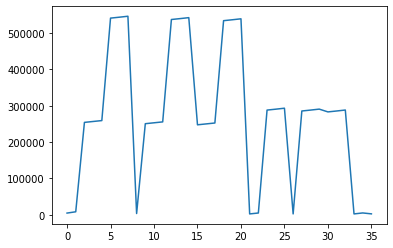

In [11]:
from bundle_adjust import ba_core

baseline_pairs, all_pairs_list = [], []
n_img = len(ba_pipeline.optical_centers)
for i in range(n_img):
    for j in range(i+1,n_img):
        
        # check if the baseline between both cameras is large enough
        current_baseline = np.linalg.norm(ba_pipeline.optical_centers[i] - ba_pipeline.optical_centers[j])
        baseline_pairs.append(current_baseline)
        all_pairs_list.append([i,j])
        
        print(len(all_pairs_list) - 1, '({},{})'.format(i, j), current_baseline, current_baseline < 150000)

fig = plt.figure()
plt.plot(baseline_pairs)
plt.show()

----- CONNECTIVITY GRAPH: 19 edges


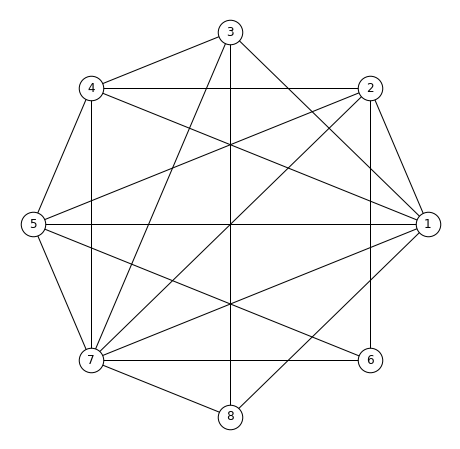

In [38]:
# check connectivity graph

ba_utils.plot_connectivity_graph(ba_pipeline.C, 10, save_pgf=False);

In [39]:
ba_utils.build_connectivity_graph(ba_pipeline.C, min_matches=10)

----- CONNECTIVITY GRAPH: 19 edges


(<networkx.classes.graph.Graph at 0x7f568783c0f0>,
 1,
 [(1, 2),
  (1, 3),
  (1, 4),
  (1, 5),
  (1, 7),
  (1, 8),
  (2, 4),
  (2, 5),
  (2, 6),
  (2, 7),
  (3, 4),
  (3, 7),
  (3, 8),
  (4, 5),
  (4, 7),
  (5, 6),
  (5, 7),
  (6, 7),
  (7, 8)],
 [43, 38, 75, 42, 88, 27, 36, 73, 39, 74, 21, 52, 50, 35, 74, 40, 74, 42, 41])

### Plot optical centers in 3D

<IPython.core.display.Javascript object>


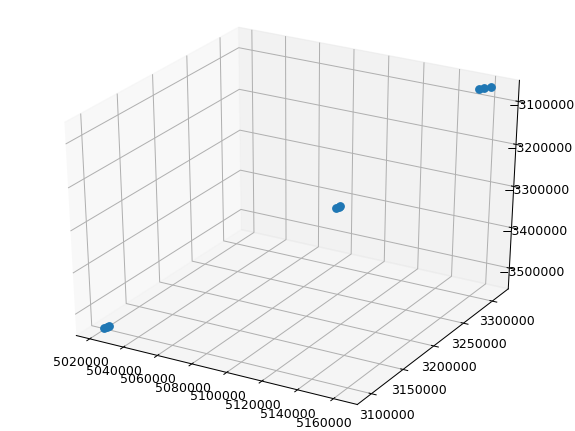

In [13]:
from bundle_adjust import rpc_utils

ocenters = np.array(ba_pipeline.optical_centers)

%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)
ax.plot(ocenters[:,0], ocenters[:,1], ocenters[:,2], 'o')